# Hyperparameter Tuning

Scikit-learn documentation:
* [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
* [Breast Cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/murilogustineli/hype-tuning/blob/main/gridsearch.ipynb)

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1: Machine Learning intro

### Load data from sklearn

In [2]:
from sklearn.datasets import load_breast_cancer

# Load Breast Cancer dataset from sklearn
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

# Data dimensions
X.shape, y.shape

((569, 30), (569,))

In [3]:
# Distribution of target variable
y.value_counts()

1    357
0    212
Name: target, dtype: int64

Dataset summary:
1. The Breast Cancer dataset has 569 instances and 31 features
    * Each instance has a binary target variable indicating the patient’s diagnosis (malignant or benign)
    * `Malignant` == 0
    * `Benign` == 1
2. The target class distribution is **imbalanced!**
    * 357 instances diagnosed as benign and 212 as malignant.

### Training a model

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

# KNN model
clf = KNeighborsClassifier()


# Fit model
clf.fit(X, y)
# Make predictions
y_pred = clf.predict(X)
# Scores
score = clf.score(X, y)
f1 = f1_score(y_pred, y)

# Scores
print(f"{clf.__class__.__name__}")
print(f"Accuracy: {round(score, 3)}")
print(f"F1 Score: {round(f1, 3)}")

KNeighborsClassifier
Accuracy: 0.947
F1 Score: 0.959


In [5]:
# DecisionTreeClassifier object
clf

KNeighborsClassifier()

In [6]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# DecisionTree
clf = DecisionTreeClassifier(max_depth=2)

# Fit model
clf.fit(X, y)
# Make predictions
y_pred = clf.predict(X)
# Scores
score = clf.score(X, y)
f1 = f1_score(y_pred, y)

# Scores
print(f"{clf.__class__.__name__}")
print(f"Accuracy: {round(score, 3)}")
print(f"F1 Score: {round(f1, 3)}")

DecisionTreeClassifier
Accuracy: 0.942
F1 Score: 0.953


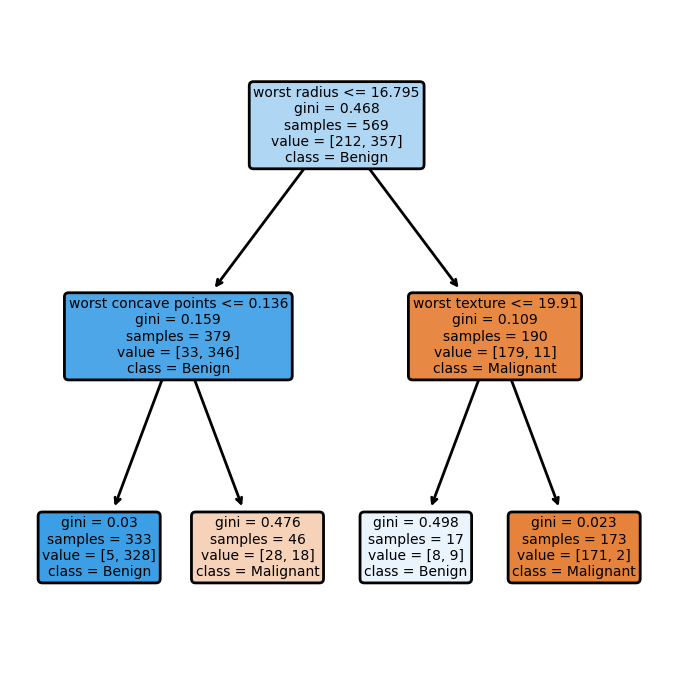

In [7]:
# Visualize Decision Tree
feature_names = list(X.columns)
class_names = ['Malignant', 'Benign'] # Malignant==0, Benign==1

# Init plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=200)
tree.plot_tree(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    fontsize=5,
    rounded=True);
fig.tight_layout(pad=3);

## Part 2: Pipelines

### Scaling features
`Scaling` features is important because it can help improve the performance of the model.
1. Scaling ensures that each feature is on a similar scale.
2. Prevents some features from dominating others in terms of their influence on teh model.
3. Help convergence of certain algorithms.
4. Make the model more robust to outliers and noise in the data.

In [8]:
# Rename columns to lower case
cols = list(X.columns)
lower_cols = [col.replace(" ", "_").lower() for col in cols]
X.columns = lower_cols

In [9]:
# Get max from each feature
mean_radius_max = np.max(X['mean_area'])
mean_area_max = np.max(X['mean_smoothness'])

print(f'Max mean area:   {mean_radius_max}')
print(f'Max mean smooth: {mean_area_max}')

Max mean area:   2501.0
Max mean smooth: 0.1634


In [10]:
# Plot different features
def plot_scales(df, feature1, feature2):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
    ax.scatter(df[feature1], df[feature2])
    ax.set_title('Different scales between two features')
    ax.set_xlabel(f"{feature1.replace('_', ' ').title()}")
    ax.set_ylabel(f"{feature2.replace('_', ' ').title()}")
    ax.grid(color='blue', linestyle='--', linewidth=1, alpha=0.2)
    ax.spines[['top', 'right']].set_visible(False)
    fig.tight_layout(pad=3)

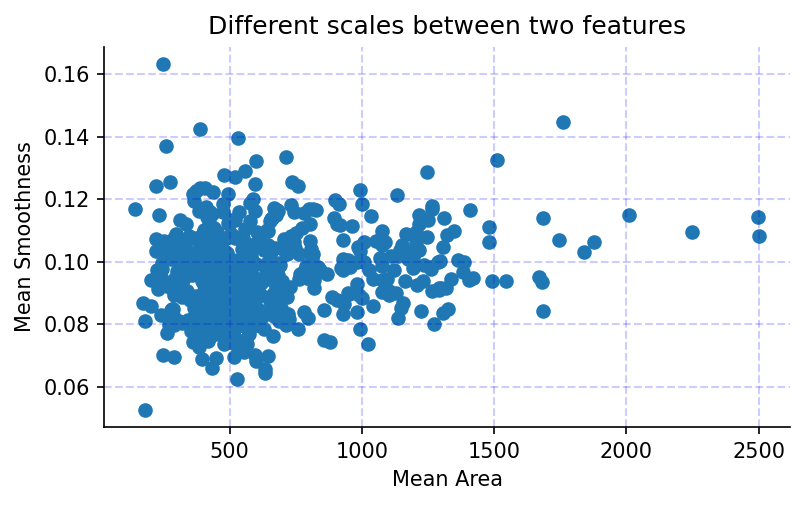

In [11]:
# Plot difference
plot_scales(df=X, feature1='mean_area', feature2='mean_smoothness')

### StandardScaler

In [12]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

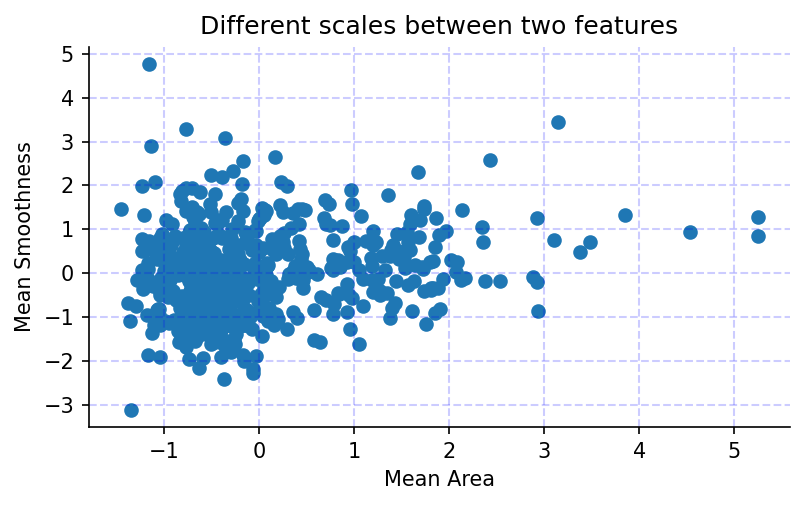

In [13]:
# Plot difference
plot_scales(df=X_scaled, feature1='mean_area', feature2='mean_smoothness')

### We have to rethink what our model actually is!

### Creating your first pipeline
Let's put everything into a pipeline!

### KNN pipeline

In [14]:
from sklearn.pipeline import Pipeline

# KNN pipeline
pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', KNeighborsClassifier())])

# Fit model
pipe.fit(X, y)
# Make predictions
y_pred = pipe.predict(X)
# Scores
score = pipe.score(X, y)
f1 = f1_score(y_pred, y)

# Scores
print(f"{pipe['model'].__class__.__name__}")
print(f"Accuracy: {round(score, 3)}")
print(f"F1 Score: {round(f1, 3)}")

KNeighborsClassifier
Accuracy: 0.981
F1 Score: 0.985


In [15]:
# Pipeline object
pipe

Pipeline(steps=[('scale', StandardScaler()), ('model', KNeighborsClassifier())])

In [16]:
# Pipeline scaler
pipe['scale']

StandardScaler()

In [17]:
# Pipeline model
pipe['model']

KNeighborsClassifier()

### DecisionTree pipeline

In [18]:
# Decision Tree pipeline
pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', DecisionTreeClassifier(max_depth=2))])

# Fit model
pipe.fit(X, y)
# Make predictions
y_pred = pipe.predict(X)
# Scores
score = pipe.score(X, y)
f1 = f1_score(y_pred, y)

print(f"Accuracy: {round(score, 3)}")
print(f"F1 Score: {round(f1, 3)}")

Accuracy: 0.942
F1 Score: 0.953


In [19]:
# Pipeline object
pipe

Pipeline(steps=[('scale', StandardScaler()),
                ('model', DecisionTreeClassifier(max_depth=2))])

### Run different pipelines

In [20]:
# Function to run pipelines
def fit_predict(pipe: object, X: pd.DataFrame,  y: pd.DataFrame):
    # Fit model
    pipe.fit(X, y)
    # Make predictions
    y_pred = pipe.predict(X)
    # Scores
    score = pipe.score(X, y)
    f1 = f1_score(y_pred, y)
    
    print(f"{str(pipe['model'].__class__.__name__)}")
    print(f"Accuracy: {round(score, 3)}")
    print(f"F1 Score: {round(f1, 3)}\n")

In [21]:
# KNN pipeline
knn_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=5))])

# Decision Tree pipeline
dt_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', DecisionTreeClassifier(max_depth=2))])

# Fit pipelines
fit_predict(pipe=knn_pipe, X=X, y=y)
fit_predict(pipe=dt_pipe, X=X, y=y)

KNeighborsClassifier
Accuracy: 0.981
F1 Score: 0.985

DecisionTreeClassifier
Accuracy: 0.942
F1 Score: 0.953



### We're making a HUGE mistake!!!
How do we know we are able to **generalize** to new data?
* We used the entire data for training and testing, and that's bad!!
* We don't want to evaluate model performance on the same dataset we used to train it.
    * **Generalization** is about the ability of a model to perform well on unseen data.
* We need to split the data intro `training` and `testing`.
    * Use the `training` data to fit the model and make predictions
    * Use the `testing` data to test the model performance

### Train/Test split

In [22]:
from sklearn.model_selection import train_test_split

# Train/Test Split using Stratified Sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train data: {X_train.shape, y_train.shape}")
print(f"Test data:  {X_test.shape, y_test.shape}")

Train data: ((455, 30), (455,))
Test data:  ((114, 30), (114,))


### Handle imbalanced data
The data is also imbalanced, where one class have more instances than another class.
* 357 instances diagnosed as `benign` and 212 as `malignant`.

In [23]:
from imblearn.over_sampling import SMOTE

# SMOTE (Synthetic Minority Oversampling Technique)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

print(f"Train data: {X_train.shape, y_train.shape}")
print(f"Test data:  {X_test.shape, y_test.shape}")

Train data: ((570, 30), (570,))
Test data:  ((114, 30), (114,))


In [24]:
# Class distribution after SMOTE
y_train.value_counts()

1    285
0    285
Name: target, dtype: int64

In [25]:
# Test data class distribution
y_test.value_counts()

1    72
0    42
Name: target, dtype: int64

### Preprocess data
Putting all the steps above together

In [26]:
# Preprocess data
def preprocess_data(test_size=0.2, oversample=False) -> tuple:
    # Load dataset
    X, y = load_breast_cancer(return_X_y=True, as_frame=True)

    # Train/Test Split using Stratified Sampling
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42)

    # Oversampling using SMOTE
    if oversample:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [27]:
# Get data
X_train, X_test, y_train, y_test = preprocess_data(test_size=0.2, oversample=True)

print(f"Train data: {X_train.shape, y_train.shape}")
print(f"Test data:  {X_test.shape, y_test.shape}")

Train data: ((570, 30), (570,))
Test data:  ((114, 30), (114,))


In [28]:
# KNN pipeline
knn_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', KNeighborsClassifier())])

# Decision Tree pipeline
dt_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', DecisionTreeClassifier(max_depth=1))])

# Fit pipelines
fit_predict(pipe=knn_pipe, X=X, y=y)
fit_predict(pipe=dt_pipe, X=X, y=y)

KNeighborsClassifier
Accuracy: 0.981
F1 Score: 0.985

DecisionTreeClassifier
Accuracy: 0.923
F1 Score: 0.94



## Part 3: GridSearch

* `GridSearch` is a technique used to find the optimal hyperparameters for a machine learning model.
* `Hyperparameters` are parameters that are set before training the model and cannot be learned from the data.
* `Hyperparameter tuning` is the process of finding the best hyperparameters for a given machine learning algorithm and dataset.
    * The performance of a machine learning model is highly dependent on the values of its hyperparameters.
    * Choosing the right hyperparameters is critical for achieving good performance.
* `Stratified Sampling` ensures the population is divided into homogeneous subgroups where the right amount of instances is sampled from each class
    * Guarantees that the test set is representative of the overall population

**Scikit-learn documentation:**
* [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [29]:
# Looking at DecisionTree parameters
dt_pipe['model'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

### GridSearch for DecisionTree

In [30]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Decision Tree pipeline
dt_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', DecisionTreeClassifier())])

# DecisionTree GridSearchCV params
dt_param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': list(range(1, 11, 1)),
    'model__min_samples_leaf': list(range(1, 11, 1))}

# Stratified sampling
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Init GridSearchCV
gridsearch = GridSearchCV(
    estimator=dt_pipe,
    param_grid=dt_param_grid,
    scoring='f1',
    cv=strat_kfold,
    verbose=2,
    n_jobs=-1)

In [31]:
# Fit model
dt_clf = gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


#### Why 200 candidates? Why 1,000 fits?

In [32]:
criterion = ['gini', 'entropy']
max_depth = list(range(1, 11, 1))
min_samples_leaf = list(range(1, 11, 1))
n_splits = 5

candidates = len(criterion) * len(max_depth) * len(min_samples_leaf)
print(f'Candidates: {candidates}')
print(f'Total fits: {candidates*n_splits}')

Candidates: 200
Total fits: 1000


In [33]:
# Look at GridSearch object
dt_clf

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'model__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10]},
             scoring='f1', verbose=2)

In [34]:
# Best estimator
dt_clf.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=5))])

In [35]:
# Best parameters
dt_clf.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 6,
 'model__min_samples_leaf': 5}

### Make predictions

In [36]:
# Train and test scores
train_score = dt_clf.score(X_train, y_train)
test_score = dt_clf.score(X_test, y_test)

print(f'Train score: {round(train_score, 3)}')
print(f'Test score:  {round(test_score, 3)}')

Train score: 0.991
Test score:  0.944


In [37]:
# F1 score
y_pred = dt_clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1 score: {round(f1, 3)}')

F1 score: 0.944


### Performance metrics

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Display scores
model_name = dt_clf.best_estimator_['model'].__class__.__name__
print(f"{dt_clf.__class__.__name__}:\t {model_name}")
print(f"Train score:     {round(train_score, 3)}")
print(f"Test score:      {round(test_score, 3)}")
print(f"Accuracy score:  {round(accuracy, 3)}")
print(f"Precision score: {round(precision, 3)}")
print(f"Recall score:    {round(recall, 3)}")
print(f"F1 score:        {round(f1, 3)}")
print(f"ROC AUC score:   {round(roc_auc, 3)}")

GridSearchCV:	 DecisionTreeClassifier
Train score:     0.991
Test score:      0.944
Accuracy score:  0.93
Precision score: 0.957
Recall score:    0.931
F1 score:        0.944
ROC AUC score:   0.93


In [39]:
# Look at GridSearchCV results
df = pd.DataFrame(gridsearch.cv_results_)
df.head(15)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014362,0.002054,0.005984,1.092280e-03,gini,1,1,"{'model__criterion': 'gini', 'model__max_depth...",0.907407,0.935780,0.859813,0.894737,0.898305,0.899208,0.024403,181
1,0.016357,0.007318,0.005186,7.465442e-04,gini,1,2,"{'model__criterion': 'gini', 'model__max_depth...",0.907407,0.935780,0.859813,0.894737,0.898305,0.899208,0.024403,181
2,0.013364,0.001493,0.005386,4.883842e-04,gini,1,3,"{'model__criterion': 'gini', 'model__max_depth...",0.907407,0.935780,0.859813,0.894737,0.898305,0.899208,0.024403,181
3,0.011569,0.001352,0.004787,3.984940e-04,gini,1,4,"{'model__criterion': 'gini', 'model__max_depth...",0.907407,0.935780,0.859813,0.894737,0.898305,0.899208,0.024403,181
4,0.010971,0.001093,0.005986,2.600544e-03,gini,1,5,"{'model__criterion': 'gini', 'model__max_depth...",0.907407,0.935780,0.859813,0.894737,0.898305,0.899208,0.024403,181
5,0.011171,0.001163,0.007579,3.545334e-03,gini,1,6,"{'model__criterion': 'gini', 'model__max_depth...",0.907407,0.935780,0.859813,0.894737,0.898305,0.899208,0.024403,181
6,0.011768,0.000747,0.004787,3.992800e-04,gini,1,7,"{'model__criterion': 'gini', 'model__max_depth...",0.907407,0.935780,0.859813,0.894737,0.898305,0.899208,0.024403,181
7,0.012567,0.001196,0.004986,8.913783e-04,gini,1,8,"{'model__criterion': 'gini', 'model__max_depth...",0.907407,0.935780,0.859813,0.894737,0.898305,0.899208,0.024403,181
8,0.012169,0.000401,0.005385,4.884267e-04,gini,1,9,"{'model__criterion': 'gini', 'model__max_depth...",0.907407,0.935780,0.859813,0.894737,0.898305,0.899208,0.024403,181
9,0.012167,0.000746,0.004788,3.973493e-04,gini,1,10,"{'model__criterion': 'gini', 'model__max_depth...",0.907407,0.935780,0.859813,0.894737,0.898305,0.899208,0.024403,181


### GridSearch for KNN

In [40]:
# KNN pipeline
knn_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', KNeighborsClassifier())])

# KNN GridSearchCV params
knn_param_grid = {
    'model__n_neighbors': list(range(5, 55, 5)),
    'model__weights' : ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']}

# Stratified sampling
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Init GridSearchCV
gridsearch = GridSearchCV(
    estimator=knn_pipe,
    param_grid=knn_param_grid,
    scoring='f1',
    cv=strat_kfold,
    verbose=2,
    n_jobs=-1)

In [41]:
# Fit model
knn_clf = gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [42]:
knn_clf.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=20,
                                      weights='distance'))])

In [43]:
# Metrics
train_score = dt_clf.score(X_train, y_train)
test_score = dt_clf.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Display scores
model_name = knn_clf.best_estimator_['model'].__class__.__name__
print(f"{knn_clf.__class__.__name__}:\t {model_name}")
print(f"Train score:     {round(train_score, 3)}")
print(f"Test score:      {round(test_score, 3)}")
print(f"Accuracy score:  {round(accuracy, 3)}")
print(f"Precision score: {round(precision, 3)}")
print(f"Recall score:    {round(recall, 3)}")
print(f"F1 score:        {round(f1, 3)}")
print(f"ROC AUC score:   {round(roc_auc, 3)}")

GridSearchCV:	 KNeighborsClassifier
Train score:     0.991
Test score:      0.944
Accuracy score:  0.93
Precision score: 0.957
Recall score:    0.931
F1 score:        0.944
ROC AUC score:   0.93


## Part 4: Going deeper

> _"Implementing machine learning is first and foremost a software endeavour, and requires experience building well architected, reliable, easy to deploy software."_

### Learner Class
Each model has its own pipeline and gridsearch parameters.

In [44]:
import time
from tqdm import tqdm
from sklearn.metrics import make_scorer, classification_report

In [45]:
# Learner class
class Learner:
    def __init__(self, pipe, params):
        self.pipe = pipe
        self.params = params
        self.clf = None
        self.scores = None
        self.search_name = None
        self.class_report = None
        self.dataset_name = None
        self.learning_curve = {}
        self.validation_curve = {}
        self.cv = StratifiedKFold(n_splits=5, shuffle=True)
        self.name = str(self.pipe['model'].__class__.__name__)
        
    def fit_gridsearch(self, search_func, X_train, y_train, verbose=False):
        np.random.seed(42)

        # Train learner
        self.clf = search_func(
            self.pipe,
            self.params,
            scoring={
                'accuracy': make_scorer(accuracy_score),
                'precision': make_scorer(precision_score),
                'recall': make_scorer(recall_score),
                'f1': make_scorer(f1_score),
                'roc_auc': make_scorer(roc_auc_score)},
            refit='f1',
            cv=self.cv,
            verbose=verbose,
            n_jobs=-1)
        # Fit the model
        self.clf.fit(X_train, y_train)
        self.search_name = str(self.clf.__class__.__name__)

    def get_scores(self, X_train, X_test, y_train, y_test):
        if self.search_name == 'Benchmark':
            best_estimator = self.clf
        else:
            best_estimator = self.clf.best_estimator_
        
        np.random.seed(42)
        # Score on training data
        start_time = time.time()
        best_estimator.fit(X_train ,y_train)
        end_time = time.time()
        wall_clock_fit = end_time - start_time
        # train_score = self.clf.score(X_train, y_train)
        train_score = best_estimator.score(X_train, y_train)

        # Score on test data
        start_time = time.time()
        # y_pred = self.clf.predict(X_test)
        y_pred = best_estimator.predict(X_test)
        end_time = time.time()
        wall_clock_pred = end_time - start_time
        # test_score = self.clf.score(X_test, y_test)
        test_score = best_estimator.score(X_test, y_test)
        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        # Classification report
        self.class_report = classification_report(y_test, y_pred)

        self.scores = {
            'train_score': round(train_score, 3),
            'test_score': round(test_score, 3),
            'accuracy': round(accuracy, 3),
            'precision': round(precision, 3),
            'recall': round(recall, 3),
            'f1': round(f1, 3),
            'roc_auc': round(roc_auc, 3),
            'wall_clock_fit': wall_clock_fit,
            'wall_clock_pred': wall_clock_pred}

    # Evaluate Learner class
    def evaluate_learner(self):
        print(f"{'#################################'*2}")
        print(f'{self.search_name}:\t  {self.name}')
        print(f"Train score:     {round(self.scores['train_score'], 3)}")
        print(f"Test score:      {round(self.scores['test_score'], 3)}")
        print(f"Accuracy score:  {round(self.scores['accuracy'], 3)}")
        print(f"Precision score: {round(self.scores['precision'], 3)}")
        print(f"Recall score:    {round(self.scores['recall'], 3)}")
        print(f"F1 score:        {round(self.scores['f1'], 3)}")
        print(f"ROC AUC score:   {round(self.scores['roc_auc'], 3)}")
        print(f"Wall Clock Fit:  {round(self.scores['wall_clock_fit'], 3)}")
        print(f"Wall Clock Pred: {round(self.scores['wall_clock_pred'], 3)}")
        # Classification report
        print(f"\nClassification report:\n{self.class_report}")
        
        # Best score and best params
        print(f"Best score: {round(self.clf.best_score_, 3)}")
        print("Best params:")
        for param in self.clf.best_params_.items():
            print(f"\t{param}")
        print()

### Pipe setup

In [85]:
def learner_setup():
    # KNN pipeline
    knn_pipe = Pipeline(steps=[
        ('scale', StandardScaler()),
        ('model', KNeighborsClassifier())])

    # GridSearchCV params
    knn_param_grid = {
        'model__n_neighbors': list(range(5, 55, 5)),
        'model__weights' : ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan']}


    # Decision Tree pipeline
    dt_pipe = Pipeline(steps=[
        ('scale', StandardScaler()),
        ('model', DecisionTreeClassifier())])

    # GridSearchCV params
    dt_param_grid = {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': list(range(1, 11, 1)),
        'model__min_samples_leaf': list(range(1, 11, 1))}


    # Init learners
    knn_grid = Learner(pipe=knn_pipe, params=knn_param_grid)
    dt_grid = Learner(pipe=dt_pipe, params=dt_param_grid)

    # Dataset name
    data_name = 'Breast Cancer'
    knn_grid.dataset_name = data_name
    dt_grid.dataset_name = data_name

    # List of learners
    learners = [knn_grid, dt_grid]

    return learners

In [86]:
# Setup learners
learners = learner_setup()

# Fit learners
with tqdm(learners, unit='batch') as tepoch:
    for learner in tepoch:
        tepoch.set_description("Training progress")   
        # Fit GridSearchCV and get scores
        learner.fit_gridsearch(GridSearchCV, X_train, y_train)
        learner.get_scores(X_train, X_test, y_train, y_test)

Training progress: 100%|██████████| 2/2 [00:16<00:00,  8.24s/batch]


In [87]:
# Evaluate learner performance
for learner in learners:
    # Evaluate learners
    learner.evaluate_learner()

##################################################################
GridSearchCV:	  KNeighborsClassifier
Train score:     1.0
Test score:      0.947
Accuracy score:  0.947
Precision score: 0.971
Recall score:    0.944
F1 score:        0.958
ROC AUC score:   0.948
Wall Clock Fit:  0.003
Wall Clock Pred: 0.113

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        42
           1       0.97      0.94      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114

Best score: 0.976
Best params:
	('model__metric', 'euclidean')
	('model__n_neighbors', 20)
	('model__weights', 'distance')

##################################################################
GridSearchCV:	  DecisionTreeClassifier
Train score:     0.991
Test score:      0.939
Accuracy score:  0.939
Precision score: 0.958
Recall score:    0

In [88]:
# Trained learners
knn, dt = learners

In [89]:
knn.clf.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=20,
                                      weights='distance'))])

In [90]:
dt.clf.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(max_depth=9, min_samples_leaf=5))])

### Comparing Performance

In [117]:
# Function to run pipelines
def fit_predict(pipe, X_train, X_test, y_train, y_test):
    # Fit model
    pipe.fit(X_train, y_train)
    # Make predictions
    y_pred = pipe.predict(X_test)
    # Scores
    score = pipe.score(X_test, y_test)
    f1 = f1_score(y_pred, y_test)
    
    # Print results
    print(f"{str(pipe['model'].__class__.__name__)}")
    print(f"Accuracy: {round(score, 3)}")
    print(f"F1 Score: {round(f1, 3)}\n")

    return round(f1, 3)

In [118]:
# KNN pipeline
knn_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=20))])

# Decision Tree pipeline
dt_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', DecisionTreeClassifier(max_depth=9))])

# Fit pipelines
knn_f1 = fit_predict(knn_pipe, X_train, X_test, y_train, y_test)
dt_f1 = fit_predict(dt_pipe, X_train, X_test, y_train, y_test)

KNeighborsClassifier
Accuracy: 0.93
F1 Score: 0.943

DecisionTreeClassifier
Accuracy: 0.93
F1 Score: 0.944



In [119]:
# KNN GridSearchCV results
print(knn.name)
print(f"Accuracy: {knn.scores['accuracy']}")
print(f"F1 Score: {knn.scores['f1']}\n")

# DecisionTree GridSearchCV results
print(knn.name)
print(f"Accuracy: {dt.scores['accuracy']}")
print(f"F1 Score: {dt.scores['f1']}")

KNeighborsClassifier
Accuracy: 0.947
F1 Score: 0.958

KNeighborsClassifier
Accuracy: 0.939
F1 Score: 0.951


### Performance Comparison

In [143]:
# Plot final results
def plot_model_results(breast_test, magic_test):
    fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
    ax.margins(x=0.1, y=0.1)  # No margins on x and y-axis
    ymin = np.min((breast_test, magic_test))
    # Learner names
    short_names = ['KNN', 'DT']
    models = ['KNN', 'DecisionTree']
    for i in range(len(models)):
        x = np.arange(len(models))
        width = 0.35
        breast_bar = ax.bar(x[i] - width/2, breast_test[i], width=width, color='tab:blue')
        magic_bar = ax.bar(x[i] + width/2, magic_test[i], width=width, color='tab:orange')
        ax.set_xticks(x, short_names)
        ax.bar_label(breast_bar, fontsize=11)
        ax.bar_label(magic_bar, fontsize=11)
    ax.set_title(f'Overall Performance', weight='bold', fontsize=16)
    ax.set_xlabel('Learning Algorithms')
    ax.set_ylabel('Test Set F1 Score')
    ax.grid(color='blue', linestyle='--', linewidth=1, alpha=0.2)
    ax.legend(['Without Tuning', 'GridSearchCV'], loc='upper right', fontsize=8)
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.set_ylim([ymin-10, 100])
    fig.tight_layout()
    # plt.savefig(f'./plots/PerformanceSummary.png')
    plt.show()

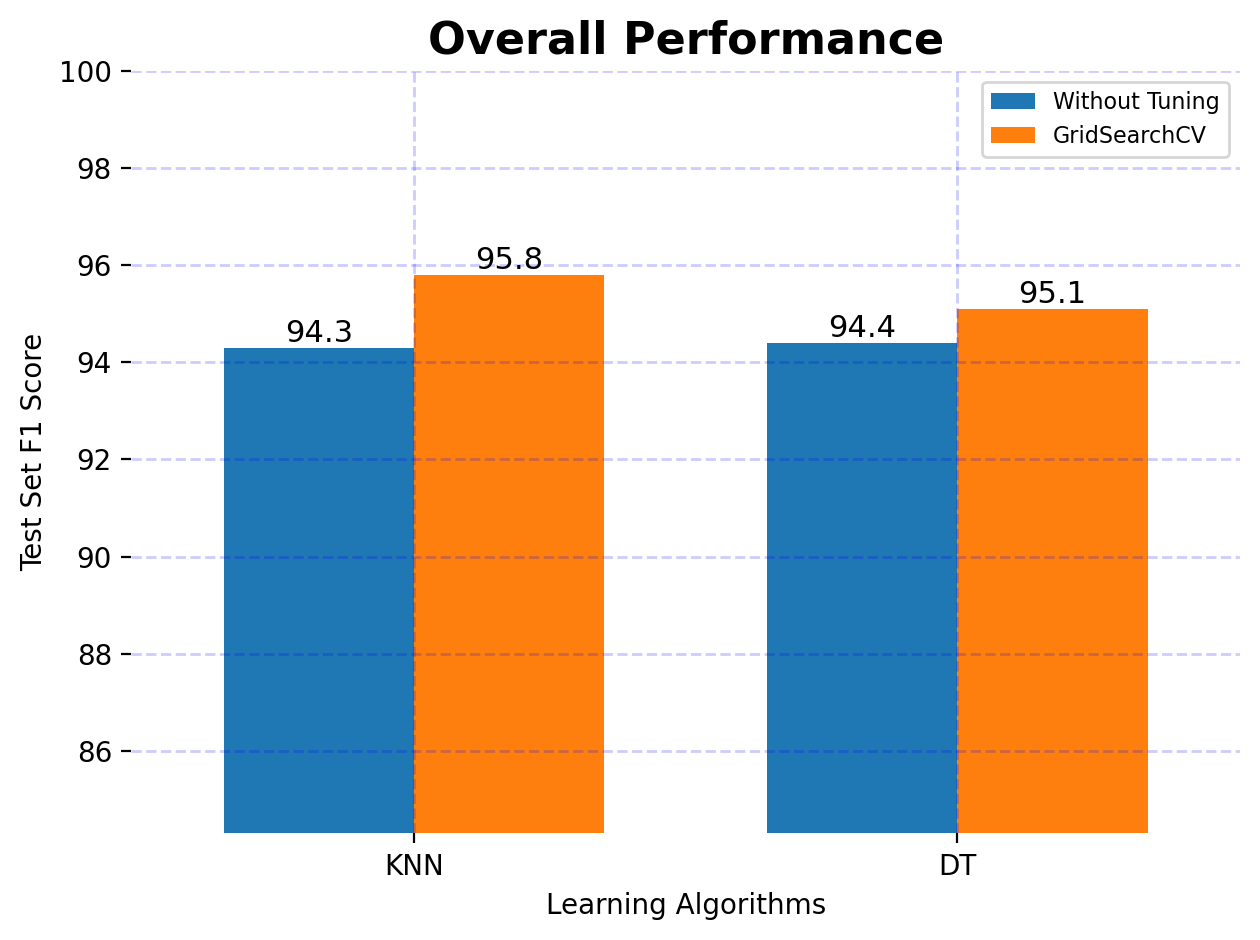

In [145]:
# Without tuning
no_search = np.multiply([knn_f1, dt_f1], 100)
# GridSearchCV
grid_search = np.multiply([knn.scores['f1'], dt.scores['f1']], 100)

# Plot results
plot_model_results(no_search, grid_search)